In [ ]:
#!pip install keras

In [ ]:
#!pip install tensorflow

In [ ]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from termcolor import colored

#import os
#import tensorflow
#os.environ['KERAS_BACKEND'] = 'tensorflow'

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences




## Read data from sentiment 140

In [ ]:
sentiment = pd.read_csv("sentiment140.csv", encoding = "ISO-8859-1")
sentiment.columns=['polarity','tweetid','date','nq','author','tweet']
sentiment = sentiment.drop(["tweetid","date","nq","author"],axis=1)

### Understanding and Checking the dataset

In [ ]:
sentiment.head(2)

In [ ]:
sentiment.shape

In [ ]:
# Check for missing data
#traindata.isnull().values.any()
#print("There is {} missing values in train data frame".format(sentiment.isnull().sum().sum()))

In [ ]:
# Check for duplicate test data
#print("There is {} duplicated values in test data frame".format(sentiment.duplicated().sum()))

In [ ]:
#duplicated = sentiment[sentiment.duplicated(keep=False)]
#duplicated.head(10) # Show us just 2 duplications

In [ ]:
# Remove duplicates
#sentiment.drop_duplicates(inplace=True)

# Confirm the removal
#print("There is {} duplicated values in data frame".format(sentiment.duplicated().sum()))
#sentiment.shape

In [ ]:
sentiment.polarity.value_counts().plot(kind="bar",subplots="True")
plt.show()

## Functions for cleaning the tweets

In [29]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
stop_words = set(stopwords.words('english'))
stop_words.remove("not")


def cleanText(s):
    bad_chars = [';', ':', '!', '*', '(' , ')', '&','[',']','.','?','{','}',',']
    non_ascii = "".join(i for i in s if ord(i)< 128)
    
    html_decoded_string = BeautifulSoup(non_ascii, "lxml")
    string = html_decoded_string.string
    
    non_name = " ".join((filter(lambda x:x[0]!='@', string.split())))
    non_badchars = ''.join(filter(lambda i: i not in bad_chars, non_name))
    non_links = re.sub(r"http\S+", "", non_badchars)
    non_websites = re.sub(r"www.[^ ]+","",non_links)
    non_numbers = re.sub(r"[0-9]+","",non_websites)
    
    clean = stopwords_stem(non_numbers)
    clean = decontracted(clean)
    
    return clean

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stopwords_stem(document): 
    words = word_tokenize(document)
    words = removeStopwords(words)
    words = stemWords(words)
    result = ""
    for word in words:
        result += word + " "
    return result

def removeStopwords(document):
    result = []
    for word in document:
        if word not in stop_words:
            result.append(word)
    return result

def stemWords(document):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    result = []
    for word in document:
        stem = stemmer.stem(word)
        result.append(stem)
    return result



## Cleaning tweets from dataframe and transform to list
#### Can skip if load from disk (below)

In [ ]:
tweets = sentiment.tweet
print("Cleaning Tweets: ")
tweets = [cleanText(t) for t in tqdm_notebook(tweets)]
polarity = sentiment.polarity

### Save the processed tweets for later use

In [ ]:
with open('tweets.pickle', 'wb') as f:
    pickle.dump(tweets, f)
with open('polarity.pickle', 'wb') as f:
    pickle.dump(polarity, f)

### Load from saved files

In [ ]:
with open('tweets.pickle', 'rb') as f:
    tweets = pickle.load(f)
with open('polarity.pickle', 'rb') as f:
    polarity = pickle.load(f)

In [ ]:
for i in range(5):
    print(sentiment.tweet[i])
    print(tweets[i]+"\n")

# TrainTestSplitToCSV

In [ ]:
# Train test split
print(colored("Splitting train and test dataset into 80:20", "yellow"))
X_train, X_test, y_train, y_test = train_test_split(tweets, polarity, test_size = 0.2, random_state = 123)
train_dataset = pd.DataFrame({
    'Tweet': X_train,
    'Sentiment': y_train
    })
print(colored("Train data distribution:", "yellow"))
print(train_dataset['Sentiment'].value_counts())
test_dataset = pd.DataFrame({
    'Tweet': X_test,
    'Sentiment': y_test
    })
print(colored("Test data distribution:", "yellow"))
print(test_dataset['Sentiment'].value_counts())
print(colored("Split complete", "yellow"))

# Save train data
print(colored("Saving train data", "yellow"))

train_dataset.to_csv('train.csv', index = False)
print(colored("Train data saved to TrainTestSplitCSV/train.csv", "green"))

# Save test data
print(colored("Saving test data", "yellow"))
test_dataset.to_csv('test.csv', index = False)
print(colored("Test data saved to TrainTestSplitCSV/test.csv", "green"))

### TF-IDF Vectorizer (SG) - can start from here after generating the data

In [1]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
print (train.shape)
train.head()

(1279999, 2)


,Tweet,Sentiment
0,u guy tour right soon,4
1,good blog post recent twitter dri grimeforum f...,0
2,brendo noooooooooooooooooooo ho earth could no...,0
3,am sorri u ' r not well sore underarm gland ...,0
4,girl burn kitten aliv In oven As `` practic jo...,0


In [2]:
test = pd.read_csv("test.csv")
print (test.shape)
test.head()

(320000, 2)


,Tweet,Sentiment
0,tire ive like hr sleep past nightsnot goooood ...,0
1,shuck miss key event week > > moan < <,0
2,Me where nice degre day I could use week themg...,0
3,it spikey dikey is last friday night the burg...,0
4,good mornin,4


In [3]:
#train.dtypes

In [4]:
# Check for duplicate train data
#print("There is {} duplicated values in train data frame".format(train.duplicated().sum()))

In [5]:
# Check for duplicate test data
#print("There is {} duplicated values in test data frame".format(test.duplicated().sum()))

In [6]:
#duplicated = train[train.duplicated(keep=False)]
#duplicated.head(10) # Show us just 2 duplications

In [7]:
# Check for missing data
#traindata.isnull().values.any()
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))
print("There is {} missing values in test data frame".format(test.isnull().sum().sum()))

There is 4494 missing values in train data frame
There is 1186 missing values in test data frame


In [8]:
# Remove null from train data
print (train.shape)
train = train.dropna()
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (train.shape)
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))

(1279999, 2)
(1275505, 2)
There is 0 missing values in train data frame


In [9]:
# Remove null from test data
print (test.shape)
test = test.dropna()
print (test.shape)
print("There is {} missing values in train data frame".format(test.isnull().sum().sum()))

(320000, 2)
(318814, 2)
There is 0 missing values in train data frame


In [10]:
x_train = train['Tweet']
y_train = train['Sentiment']
x_test = test["Tweet"]
y_test = test['Sentiment']

In [11]:
print (x_train.shape, x_test.shape)
print (y_train.shape, y_test.shape)

(1275505,) (318814,)
(1275505,) (318814,)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
#vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
#kagtest_vectors = vectorizer.transform(testdata['Comment'])

In [13]:
print (train_vectors.shape)

(1275505, 3329685)


## Exploring with Different Classifcation Models (SG)
As a few models are done at the same time, this part of the program do take a while.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time
import csv

nb = MultinomialNB()
svm = SVC(kernel='linear')
# GridSearchCV Optimised 
#svm = SVC(kernel='rbf')
lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 1, penalty= 'l2')
# GridSearchCV Optimised 
#lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 2, penalty= 'l2')
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_samples_leaf=50, random_state=13)
rf = RandomForestClassifier(n_estimators=10)
knn = KNeighborsClassifier(n_neighbors=10)
ada = AdaBoostClassifier(n_estimators=25)
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), activation='relu', solver='adam', max_iter=100)
et = ExtraTreesClassifier(n_estimators = 100)          
gb = GradientBoostingClassifier(n_estimators = 100)    
xgb = XGBClassifier(n_estimators= 2000, learning_rate=0.01)

# define models
#models = {"Naive Bayes" : nb,
#          "SVM" : svm,
#          "Logistic Regression" : lr,
#          "Decision Tree" : dt,
#          "Random Forest" : rf,
#          "KNeighborst" : knn,
#          "AdaBoost" : ada,
#          "Multi-Layer Perceptron" : mlp,
#          "Extra Trees" : et,
#          "Gradient Boosting" : gb,
#          "Extreme Gradient Boosting" : xgb}
models = {"Naive Bayes" : nb,
          "Logistic Regression" : lr,
          "Decision Tree" : dt,
          "AdaBoost" : ada}

# Open file to write result of various models 
csvFile = open("result.csv", 'w+', newline='')
writer = csv.writer(csvFile)
writer.writerow(('Model','Accuracy(train)','Accuracy(test)','Time'))

# iterate through all models

for key, value in models.items():   
    start_time = time.time()
    model = value

    # fit & predict training score
    model.fit(train_vectors, y_train)
    y_train_predict = model.predict(train_vectors)
    y_test_predict = model.predict(test_vectors)
    
    accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
    accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)
#    accuracy3 = round(f1_score(y_test, y_test_predict), 5)
    print (key, 'testing accuracy', accuracy2)
    end_time = time.time()
    elapsed_time = round((end_time - start_time), 5)

    # Write result to file
    writer.writerow ((key, accuracy1, accuracy2, elapsed_time))

    # save the model to disk
    #filename = 'finalized_model.sav'
    filename = key + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    
#    # Make predictions on test data
#    kag_y_test_predict = model.predict(kagtest_vectors)
    
#    # Prepare submission file   
#    testdata['Outcome'] = kag_y_test_predict
#    df_submit = testdata[['Id', 'Outcome']]
#    filename = key + '_10.csv'
#    df_submit.to_csv(filename, index=False, header=True)

### CLOSE CSV FILE
csvFile.close()

Naive Bayes testing accuracy 0.78872
Logistic Regression testing accuracy 0.80655
Decision Tree testing accuracy 0.61624
AdaBoost testing accuracy 0.67328


In [15]:
# Read result file from CSV
result = pd.read_csv("result.csv")

# sort by testing accuracy
print ('Sort by Testing Accuracy for the various models')
result.sort_values(by=["Accuracy(test)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

# TF-IDF
#Logistic Regression	0.79415	0.78469	11.47858
#Naive Bayes        	0.77418	0.76226	0.47203
#Decision Tree      	0.61696	0.61683	21.06831

# TF-IDF (ngrams)
#ngram = (1,2)
#vectorizer = TfidfVectorizer(ngram_range = ngram)
#Logistic Regression 	0.86243	0.80435	42.32039
#Naive Bayes         	0.89943	0.78625	1.13861
#Decision Tree       	0.61743	0.61716	64.05016

Sort by Testing Accuracy for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Logistic Regression,0.86310,0.80655,49.45486
Naive Bayes,0.89906,0.78872,1.17934
AdaBoost,0.67358,0.67328,220.05336
Decision Tree,0.61586,0.61624,69.41445


Graph showing the Testing Accuracy for the various models


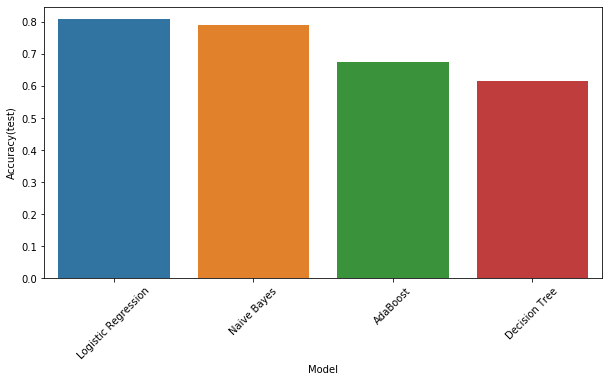

In [16]:
import seaborn as sns
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# Plot testing accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(test)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Testing Accuracy for the various models')

In [17]:
# Read result file from CSV
result = pd.read_csv("result.csv")

# sort by training accuracy
print ('Sort by Training Accuracy for the various models')
result.sort_values(by=["Accuracy(train)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

Sort by Training Accuracy for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89906,0.78872,1.17934
Logistic Regression,0.86310,0.80655,49.45486
AdaBoost,0.67358,0.67328,220.05336
Decision Tree,0.61586,0.61624,69.41445


Graph showing the Training Accuracy for the various models


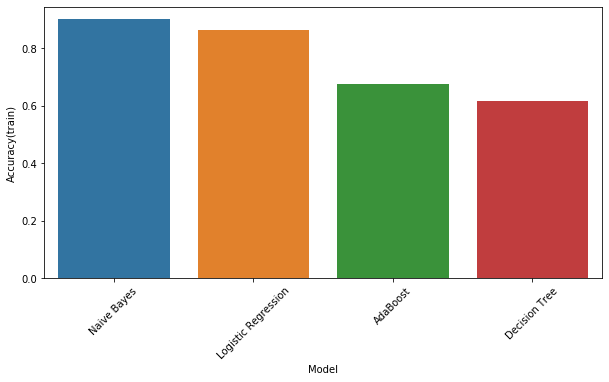

In [18]:
# Plot training accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(train)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Training Accuracy for the various models')

In [19]:
# sort by timing
print ('Sort by Processing Time for the various models')
result.sort_values(by=["Time"], axis=0 ,ascending=True, inplace=True)
result.set_index('Model')

Sort by Processing Time for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89906,0.78872,1.17934
Logistic Regression,0.86310,0.80655,49.45486
Decision Tree,0.61586,0.61624,69.41445
AdaBoost,0.67358,0.67328,220.05336


Graph showing the processing time for the various models


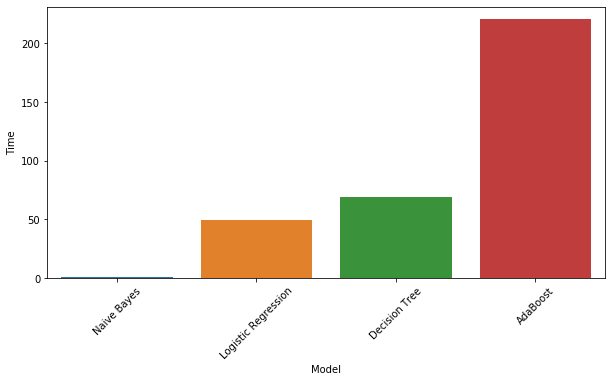

In [20]:
# Plot training time for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Time"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the processing time for the various models')

#### The program shows that logistic regression classifier produces the best testing accuracy

### Optimizing the Hyperparameters of Logistic Regression

In [33]:
#Step 1 : determine the best solver
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lg = LogisticRegression( class_weight="balanced", random_state=42, max_iter=10000, penalty = 'l2')
grid = {'solver': ['liblinear', 'lbfgs', 'sag', 'saga']} 
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

Tuned hyperparameter parameters: {'solver': 'liblinear'}
Best cross-validation score: 0.8027949714034832


In [34]:
#Step 2 : Using solver = liblinear, determine the best C value
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lg = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, penalty = 'l2')
grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

Tuned hyperparameter parameters: {'C': 1}
Best cross-validation score: 0.8027949714034832


In [35]:
#Step 3 : Fine tuning the C value 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
lg = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, penalty = 'l2')
grid = {"C" : np.arange(0.5,2.51,0.1)}
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

Tuned hyperparameter parameters: {'C': 1.7999999999999998}
Best cross-validation score: 0.804008608355122


### The best hyperparameters are solver = liblinear and C = 1.8

### Cross Validation 
https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79

Cross Validation is used to assess the predictive performance of the models and and to judge how they perform outside the sample to a new data set also known as test data. The motivation to use cross validation techniques is that when we fit a model, we are fitting it to a training dataset.

In [36]:
# Cross validation for top 4 algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

nb = MultinomialNB()
lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 1.8, penalty= 'l2')
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_samples_leaf=50, random_state=13)
ada = AdaBoostClassifier(n_estimators=100)       

accuracies_lr = cross_val_score(estimator=lr, X=train_vectors, y=y_train, cv=10)
print("Logistic Regression Average accuracy: ", accuracies_lr.mean())
print("Logistic Regression Standard Deviation: ", accuracies_lr.std())

#accuracies_dt = cross_val_score(estimator=dt, X=train_vectors, y=y_train, cv=10)
#print("Decision Tree Average accuracy: ", accuracies_dt.mean())
#print("Decision Tree Standard Deviation: ", accuracies_dt.std())

#accuracies_nb = cross_val_score(estimator=nb, X=train_vectors, y=y_train, cv=10)
#print("Naive Bayes Average accuracy: ", accuracies_dt.mean())
#print("Naive Bayes Standard Deviation: ", accuracies_dt.std())

#accuracies_ada = cross_val_score(estimator=ada, X=train_vectors, y=y_train, cv=10)
#print("AdaBoosting Average accuracy: ", accuracies_ada.mean())
#print("AdaBoosting Standard Deviation: ", accuracies_ada.std())

Logistic Regression Average accuracy:  0.804909427397441
Logistic Regression Standard Deviation:  0.0010851795233134483


In [22]:
# Using the best parameters to build and save model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
import csv

lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 1.8, penalty= 'l2')
print (lr)  

# fit & predict training score
model = lr.fit(train_vectors, y_train)
y_train_predict = model.predict(train_vectors)
y_test_predict = model.predict(test_vectors)
    
accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)
print ('Optimized Logistic Regression Training accuracy:', accuracy1)
print ('Optimized Logistic Regression Testing accuracy:', accuracy2)
print('Confusion metrics :\n', metrics.confusion_matrix(y_test, y_test_predict))

# save the model to disk
filename = 'lropt_model.sav'
pickle.dump(model, open(filename, 'wb'))


LogisticRegression(C=1.8, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=42, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)
Optimized Logistic Regression Training accuracy: 0.89084
Optimized Logistic Regression Testing accuracy: 0.80734
Confusion metrics :
 [[128471  30886]
 [ 30537 128920]]


# Classification of NTU, NUS & SMU Tweets

In [53]:
#Reading tweets from NTU, NUS & SMU
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook

In [66]:
ntu = pd.read_csv("ntu0.csv")
nus = pd.read_csv("nus0.csv")
smu = pd.read_csv("smu0.csv")
ntu = ntu.drop(["tweet_id", "keyword","user"],axis=1)
nus = nus.drop(["tweet_id","keyword","user"],axis=1)
smu = smu.drop(["tweet_id","keyword","user"],axis=1)
print (ntu.shape, nus.shape, smu.shape)
ntu.head()

(2383, 3) (2818, 3) (3000, 3)


,Unnamed: 0,tweet,date_tweet
0,0,@IruraMwongera @Amen_Baba_ KOUMA (to be dry KM...,9/2/2020 7:36
1,1,You know how everyone’s introducing themselves...,9/2/2020 7:25
2,2,is ntu rly not gonna move big-group lectures o...,9/2/2020 7:07
3,3,"But also, the Chinese speaking groups that ope...",9/2/2020 6:19
4,4,@MigunaMiguna @DrMumbiSeraki When your faced w...,9/2/2020 5:54


In [67]:
from tqdm import tqdm_notebook
ntutweets = ntu.tweet
nustweets = nus.tweet
smutweets = smu.tweet
print("Cleaning Tweets: ")
ntutweets = [cleanText(t) for t in tqdm_notebook(ntutweets)]
nustweets = [cleanText(t) for t in tqdm_notebook(nustweets)]
smutweets = [cleanText(t) for t in tqdm_notebook(smutweets)]
ntudate = ntu.date_tweet
nusdate = nus.date_tweet
smudate = smu.date_tweet


Cleaning Tweets: 


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Save tweets for use later

In [68]:
#Save the processed tweets for later use
# save ntu tweets
with open('ntutweets.pickle', 'wb') as f:
    pickle.dump(ntutweets, f)
with open('ntudate.pickle', 'wb') as f:
    pickle.dump(ntudate, f)

# save nus tweets
with open('nustweets.pickle', 'wb') as f:
    pickle.dump(nustweets, f)
with open('nusdate.pickle', 'wb') as f:
    pickle.dump(nusdate, f)  

# save smu tweets
with open('smutweets.pickle', 'wb') as f:
    pickle.dump(smutweets, f)
with open('smudate.pickle', 'wb') as f:
    pickle.dump(smudate, f)    

### Load the tweets on various universities and saving to csv

In [69]:
# Load ntu data
with open('ntutweets.pickle', 'rb') as f:
    ntutweets = pickle.load(f)
with open('ntudate.pickle', 'rb') as f:
    ntudate = pickle.load(f)
    
# Load nus data
with open('nustweets.pickle', 'rb') as f:
    nustweets = pickle.load(f)
with open('nusdate.pickle', 'rb') as f:
    nusdate = pickle.load(f)
    
# Load smu data
with open('smutweets.pickle', 'rb') as f:
    smutweets = pickle.load(f)
with open('smudate.pickle', 'rb') as f:
    smudate = pickle.load(f)

In [70]:
### Saving tweets as dataframe

In [71]:
from termcolor import colored
# Save as dataframe
ntu_data = pd.DataFrame({
    'Tweet': ntutweets,
    'Date': ntudate
    })

nus_data = pd.DataFrame({
    'Tweet': nustweets,
    'Date': nusdate
    })

smu_data = pd.DataFrame({
    'Tweet': smutweets,
    'Date': smudate
    })

# Save data
print(colored("Saving data", "blue"))
ntu_data.to_csv('ntu_data.csv', index = False)
nus_data.to_csv('nus_data.csv', index = False)
smu_data.to_csv('smu_data.csv', index = False)
ntu_data.head()

Saving data


,Tweet,Date
0,kouma dri KM kaa ukaa charcoal appear = black ...,9/2/2020 7:36
1,you know everyon introduc ntu student pursu ba...,9/2/2020 7:25
2,ntu rli not gon na move big-group lectur onlin,9/2/2020 7:07
3,but also chines speak group oper dialect would...,9/2/2020 6:19
4,when face forc mightier It advis humbl even ri...,9/2/2020 5:54


### Load the CSV files on various universities 

In [72]:
ntu_data = pd.read_csv("ntu_data.csv")
print (ntu_data.shape)
ntu_data.head()

nus_data = pd.read_csv("nus_data.csv")
print (nus_data.shape)
nus_data.head()

smu_data = pd.read_csv("smu_data.csv")
print (smu_data.shape)
smu_data.head()

(2383, 2)
(2818, 2)
(3000, 2)


,Tweet,Date
0,miss smu much,14/2/2020 7:52
1,happi valentin everyon special loml,14/2/2020 7:48
2,move friday # unt # uta # smu # utd # tcu,14/2/2020 7:30
3,now parad beauti smu # smucampusperson,14/2/2020 7:26
4,Go get r done sunday stud love watch smu,14/2/2020 7:15


In [73]:
# Remove null from ntu data

#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (ntu_data.shape)
print("There is {} missing values in ntu data frame".format(ntu_data.isnull().sum().sum()))
ntu_data = ntu_data.dropna()
print (ntu_data.shape)

# Remove null from nus data
print (nus_data.shape)
print("There is {} missing values in nus data frame".format(nus_data.isnull().sum().sum()))
nus_datadata = nus_data.dropna()

# Remove null from smu data
print("There is {} missing values in smu data frame".format(ntu_data.isnull().sum().sum()))
smu_data = smu_data.dropna()
print (smu_data.shape)

(2383, 2)
There is 3 missing values in ntu data frame
(2380, 2)
(2818, 2)
There is 0 missing values in nus data frame
There is 0 missing values in smu data frame
(2997, 2)


In [74]:
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("test.csv", encoding = "ISO-8859-1")
train = train.dropna()
test = test.dropna()
x_train = train['Tweet']
y_train = train['Sentiment']
x_test = test["Tweet"]
y_test = test['Sentiment']

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
#vectorizer = TfidfVectorizer(min_df = 5,
#                             max_df = 0.8,
#                             sublinear_tf = True,
#                             use_idf = True)
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
ntu_vectors = vectorizer.transform(ntu_data['Tweet'])
nus_vectors = vectorizer.transform(nus_data['Tweet'])
smu_vectors = vectorizer.transform(smu_data['Tweet'])

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import time
import csv

# load the model from disk
loaded_model = pickle.load(open('lropt_model.sav', 'rb'))

#Checking the training and testing accuracy
y_train_predict = loaded_model.predict(train_vectors)
y_test_predict = loaded_model.predict(test_vectors)
    
accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)

print (key, 'testing accuracy', accuracy2)
print (key, 'training accuracy', accuracy1) 
    
# Make classification on tweets data
print ('Classifying NTU Tweets')
ntu_y_test_predict = loaded_model.predict(ntu_vectors)

print ('Classifying NUS Tweets')
nus_y_test_predict = loaded_model.predict(nus_vectors)

print ('Classifying SMU Tweets')
smu_y_test_predict = loaded_model.predict(smu_vectors)
    
# Prepare analysis file
# NTU
ntu_data['Sentiment'] = ntu_y_test_predict
ntu_submit = ntu_data[['Date', 'Sentiment']]
ntu_submit.to_csv('ntu_sent.csv', index=False, header=True)

# NUS
nus_data['Sentiment'] = nus_y_test_predict
nus_submit = nus_data[['Date', 'Sentiment']]
nus_submit.to_csv('nus_sent.csv', index=False, header=True)

# SMU
smu_data['Sentiment'] = smu_y_test_predict
smu_submit = smu_data[['Date', 'Sentiment']]
smu_submit.to_csv('smu_sent.csv', index=False, header=True)


AdaBoost testing accuracy 0.80734
AdaBoost training accuracy 0.89084
Classifying NTU Tweets
Classifying NUS Tweets
Classifying SMU Tweets


### We can start understand the tweets from the classification

In [77]:
ntu_sent = pd.read_csv("ntu_sent.csv")
nus_sent = pd.read_csv("nus_sent.csv")
smu_sent = pd.read_csv("smu_sent.csv")
ntu_sent.head()
ntu_sent.describe()

,Sentiment
count,2380.000000
mean,2.857143
std,1.807396
min,0.000000
25%,0.000000
50%,4.000000
75%,4.000000
max,4.000000


### ???? To try multiplot on same graph

NTU Sentiment distribution:
4    1700
0     680
Name: Sentiment, dtype: int64
NUS Sentiment distribution:
4    1810
0    1008
Name: Sentiment, dtype: int64


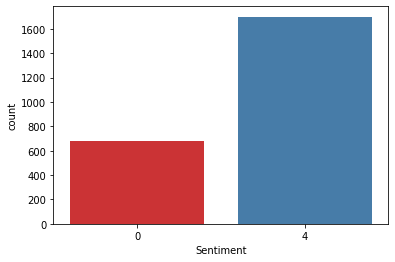

In [81]:
#### to try
# checking dataset of NTU - try to use multiplot on same graph
print(colored("NTU Sentiment distribution:", "red"))
print(ntu_sent['Sentiment'].value_counts())
print(colored("NUS Sentiment distribution:", "blue"))
print(nus_sent['Sentiment'].value_counts())

import seaborn as sns
ntu_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
sns.countplot(x="Sentiment", data=ntu_sent, palette="Set1")
#print ('NTU Tweets Sentiment')

#nus_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
#sns.countplot(x="Sentiment", data=nus_sent, palette="Set1", newfig=False)
#print ('NTU/NUS Tweets Sentiment')

# test 7; more than one file per figure--illustrated here with a single file
#plt.plotfile(fname2, cols=(0, 1), delimiter=' ')
#plt.plotfile(fname2, cols=(0, 2), newfig=False,
#             delimiter=' ')  # use current figure

In [ ]:
# checking dataset of NTU
import seaborn as sns
ntu_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
sns.countplot(x="Sentiment", data=ntu_sent, palette="Set1")
print ('NTU Tweets Sentiment')

print(colored("NTU Sentiment distribution:", "red"))
print(ntu_sent['Sentiment'].value_counts())


In [ ]:
# checking dataset of NUS
import seaborn as sns
nus_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
sns.countplot(x="Sentiment", data=nus_sent, palette="Set1")
print ('NUS Tweets Sentiment')

# test 7; more than one file per figure--illustrated here with a single file
#plt.plotfile(fname2, cols=(0, 1), delimiter=' ')
#plt.plotfile(fname2, cols=(0, 2), newfig=False,
#             delimiter=' ')  # use current figure

print(colored("NUS Sentiment distribution:", "blue"))
print(nus_sent['Sentiment'].value_counts())

In [ ]:
# checking dataset of SMU
import seaborn as sns
smu_sent.groupby("Sentiment").count()
sns.countplot(x="Sentiment", data=smu_sent, palette="Set1")
print ('SMU Tweets Sentiment')

print(colored("SMU Sentiment distribution:", "grey"))
print(smu_sent['Sentiment'].value_counts())

In [ ]:
# https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html
#plot data
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['date','type']).count()['amount'].plot(ax=ax)

# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)

In [ ]:
# http://blog.yhat.com/posts/aggregating-and-plotting-time-series-in-python.html

In [ ]:
#dftest.date = pd.to_datetime(dftest.date).dt.to_period('y')
#dftest.head(2)
ntu_sent.Date = pd.to_datetime(ntu_sent.Date).dt.to_period('m')
ntu_sent.Date.head(10)

In [ ]:
ntu_sent.Date.tail(10)

In [ ]:
# Explore at what sentiment by date
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='Date', hue='Sentiment', data = ntu_sent, palette="Set1");

In [ ]:
# visualize cardio with gender
sns.countplot(x='Date',data=ntu_sent,hue='Sentiment',palette='rainbow')
print ('Visualize NTU sentiment with date')

In [ ]:
# store the vocabulary of X_train
x_train_tokens = vectorizer.get_feature_names()
len(x_train_tokens)

# first row is negative, second row is positive reviews
loaded_model.feature_count_.shape


# store the number of times each token appears across each class
negative_token_count = nb.feature_count_[0, :]
positive_token_count = nb.feature_count_[1, :]


# create a DataFrame of tokens with their separate one-star and five-star counts
tokens = pd.DataFrame({'token':x_train_tokens, 'one_star':negative_token_count, 'five_star':positive_token_count}).set_index('token')


# add 1 to one-star and five-star counts to avoid dividing by 0
tokens['negative'] = tokens.negative + 1
tokens['positve'] = tokens.postive + 1


# first number is one-star reviews, second number is five-star reviews
loaded_model.class_count_


# convert the one-star and five-star counts into frequencies
tokens['negative'] = tokens.negative / nb.class_count_[0]
tokens['postive'] = tokens.postive / nb.class_count_[1]


# calculate the ratio of five-star to one-star for each token
tokens['postive_ratio'] = tokens.postive / tokens.negative


# sort the DataFrame by five_star_ratio (descending order), and examine the first 10 rows
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('positve_ratio', ascending=False).head(10)


# sort the DataFrame by five_star_ratio (ascending order), and examine the first 10 rows
tokens.sort_values('postive_ratio', ascending=True).head(10)

# LSTM

In [ ]:
# Load data
print(colored("Loading train and test data", "yellow"))
train_data = pd.read_csv('C:/Users/Phu Wai Paing/Desktop/Course Books/Text and Web Mining/TrainTestSplitCSV/train.csv')
test_data = pd.read_csv('C:/Users/Phu Wai Paing/Desktop/Course Books/Text and Web Mining/TrainTestSplitCSV/test.csv')
print(colored("Data loaded", "yellow"))

# Tokenization
print(colored("Tokenizing and padding data", "yellow"))
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)
print(colored("Tokenizing and padding complete", "yellow"))

# Building the model
print(colored("Creating the LSTM model", "yellow"))
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

# Training the model
print(colored("Training the LSTM model", "green"))
history = model.fit(train_tweets, pd.get_dummies(train_data['Sentiment']).values, epochs = 1, batch_size = 128, validation_split = 0.2)
print(colored(history, "green"))

# Testing the model
print(colored("Testing the LSTM model", "green"))
score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['Sentiment']).values, batch_size = 128)
print("Test accuracy: {}".format(accuracy))